In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import OneHotEncoder

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

dataset_path = "../datasets/taobao"

cuda:0


___

In [2]:
raw_sample = pd.read_csv(dataset_path + "/raw/raw_sample.csv", sep = ",",encoding ="ISO-8859-1").drop(['time_stamp', 'pid', 'nonclk'], axis=1).dropna()

raw_sample.adgroup_id = raw_sample.adgroup_id.astype(int)

print(raw_sample.shape)
#print((raw_sample.nonclk.astype(bool).apply(lambda x: not x).values == raw_sample.clk.astype(bool).values).all())
#np.sum(raw_sample['clk'].values)
raw_sample.head()

(9979308, 3)


,user,adgroup_id,clk
0,581738,1,0.0
1,449818,3,0.0
2,914836,4,0.0
3,914836,5,0.0
4,399907,8,0.0


In [3]:
print(len(set(raw_sample["adgroup_id"])))
print(len(set(raw_sample["user"])))

344252
1014096


In [4]:
user = pd.read_csv(dataset_path + "/raw/user_profile.csv", sep = ",",encoding ="ISO-8859-1").dropna()
user = user.loc[user['userid'].isin(raw_sample["user"])].reset_index(drop=True)

top_n = 10

top_cms_segid_index = user.groupby("cms_segid").count().sort_values("userid", ascending = False).head(top_n).reset_index()["cms_segid"]

user = user.loc[user['cms_segid'].isin(top_cms_segid_index)].reset_index(drop=True)

columnsToEncode = list(user.columns)[1:]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(user[columnsToEncode])

user_features = pd.concat([user.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(user[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names(columnsToEncode))], axis=1).reset_index(drop=True)
print(user_features.shape)
user_id_to_feature = dict(zip(user_features.values[:,0].astype(np.int64),user_features.values[:,1:]))
user_features.head()

(162790, 32)


/tmp/ipykernel_18592/2433226647.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  user_features = pd.concat([user.drop(columnsToEncode, 1),
/home/junghunkim/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,userid,cms_segid_2,cms_segid_5,cms_segid_7,cms_segid_8,cms_segid_19,cms_segid_20,cms_segid_33,cms_segid_34,cms_segid_44,...,pvalue_level_1.0,pvalue_level_2.0,pvalue_level_3.0,shopping_level_3,occupation_0,occupation_1,new_user_class_level _1.0,new_user_class_level _2.0,new_user_class_level _3.0,new_user_class_level _4.0
0,5777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,6355,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,6972,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,10122,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,11256,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [5]:
ad_feature_ = pd.read_csv(dataset_path + "/raw/ad_feature.csv", sep = ",",encoding ="ISO-8859-1").dropna()
ad_feature_['brand'] = ad_feature_['brand'].astype(np.int64)
ad_feature_ = ad_feature_.loc[ad_feature_['adgroup_id'].isin(raw_sample["adgroup_id"])].reset_index(drop=True)

ad_feature_ = ad_feature_.drop(['customer', 'campaign_id'], axis=1)

ad_feature_.price = ad_feature_.price.apply(lambda x: math.ceil(math.log10(x)))

top_n = 25

top_cate_id_index = ad_feature_.groupby("cate_id").count().sort_values("adgroup_id", ascending = False).head(top_n).reset_index()["cate_id"]
top_brand_index   = ad_feature_.groupby("brand").count().sort_values("adgroup_id", ascending = False).head(top_n).reset_index()["brand"]

ad_feature = ad_feature_.loc[ad_feature_['cate_id'].isin(top_cate_id_index)]
ad_feature = ad_feature.loc[ad_feature['brand'].isin(top_brand_index)].reset_index(drop=True)

print(ad_feature['adgroup_id'])

columnsToEncode = list(ad_feature.columns)[1:]
myEncoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
myEncoder.fit(ad_feature[columnsToEncode])

ad_features = pd.concat([ad_feature.drop(columnsToEncode, 1),
                           pd.DataFrame(myEncoder.transform(ad_feature[columnsToEncode]), 
                                        columns = myEncoder.get_feature_names(columnsToEncode))], axis=1).reset_index(drop=True)

adgroup_id_to_feature = dict(zip(ad_features.values[:,0].astype(np.int64),ad_features.values[:,1:]))

ad_features.head()

0       773024
1       771894
2       319109
3       345310
4       732637
         ...  
6624    829687
6625    656988
6626    760217
6627    772808
6628    741074
Name: adgroup_id, Length: 6629, dtype: int64


/tmp/ipykernel_18592/640655382.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  ad_features = pd.concat([ad_feature.drop(columnsToEncode, 1),
/home/junghunkim/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,adgroup_id,cate_id_856,cate_id_1535,cate_id_1665,cate_id_4267,cate_id_4280,cate_id_4281,cate_id_4282,cate_id_4283,cate_id_4284,...,brand_293023,brand_342760,brand_353787,brand_425589,brand_454237,price_0,price_1,price_2,price_3,price_4
0,773024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,771894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,319109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,345310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,732637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
raw_sample = raw_sample.loc[raw_sample['user'].isin(user_features['userid'])]
raw_sample = raw_sample.loc[raw_sample['adgroup_id'].isin(ad_features['adgroup_id'])].reset_index(drop=True)

print(raw_sample.shape)
raw_sample.head()

(63198, 3)


,user,adgroup_id,clk
0,771736,767,0.0
1,487285,767,0.0
2,520892,767,0.0
3,521847,767,0.0
4,80312,767,0.0


In [7]:
data_array = raw_sample.values

Y = data_array[:,2]

X = []
for i in range(data_array.shape[0]):
    user_id = data_array[i,0].astype(np.int64)
    movie_id= data_array[i,1].astype(np.int64)
    
    feature = np.concatenate((user_id_to_feature[user_id], adgroup_id_to_feature[movie_id])).copy()
    X.append(feature)
    
X = np.vstack(X)
X.shape, Y.shape

((63198, 84), (63198,))

In [8]:
data_tail = '_taobao'

reward0_idx = np.where(Y == 0)[0]
reward1_idx = np.where(Y == 1)[0]

len(reward0_idx), len(reward1_idx)

(59366, 3832)

In [9]:
np.save(dataset_path+'/preprocess/X0{}'.format(data_tail),X[reward0_idx,:])
np.save(dataset_path+'/preprocess/X1{}'.format(data_tail),X[reward1_idx,:])

_________________________________

## Train Autoencoder

In [10]:
data_tail = '_taobao'
EMB_DIM = 32
save_tail = '_taobao32'

# Hyperparameters for Training
learning_rate = 0.00005
weight_decay  = 0.00001
num_epoch = 4000 #Normally 100
B = 10000 # batchsize

class BN_Autoencoder(nn.Module):
    def __init__(self, d, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.d = d
        self.encoder = nn.Sequential(nn.Linear(self.d, self.emb_dim),nn.BatchNorm1d(self.emb_dim))
        self.decoder = nn.Linear(self.emb_dim, self.d)
                
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, self.d)
        return out
    
    def encoding_result(self, x):
        batch_size = x.shape[0]
        x = x.view(x.shape[0],-1)
        encoded = self.encoder(x)
        return encoded

In [11]:
X = np.vstack([np.load(dataset_path+'/preprocess/X0{}.npy'.format(data_tail)),np.load(dataset_path+'/preprocess/X1{}.npy'.format(data_tail))])
np.random.shuffle(X)
d = X.shape[1]

model = BN_Autoencoder(d=d, emb_dim=EMB_DIM).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [12]:
L = X.shape[0]

loss_arr = []

for k in tqdm.tqdm(range(num_epoch)):
    
    for l in range(L//B):
        
        batch  = X[l*B:(l+1)*B, :].copy()
        
        x = torch.from_numpy(batch).type(torch.FloatTensor).to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
    
    loss_val = loss.cpu().data.numpy()
    loss_arr.append(loss_val)

100%|██████████| 4000/4000 [01:20<00:00, 49.86it/s]


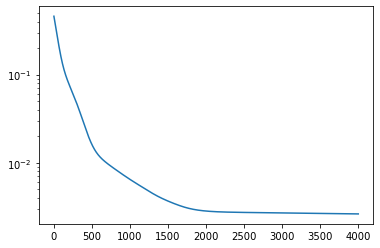

In [13]:
plt.plot(loss_arr)
plt.yscale("log")

In [14]:
# Save Autoencoder
torch.save(model.state_dict(), '../models/taobao_autoencoder{}.pt'.format(save_tail))